In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [1]:
# fetch data from Yahoo Finance
ticker = "^NDX"  # NASDAQ 100
data = yf.download(ticker, period="max", interval="1d")  # daily data
data = data[['Close']]

NameError: name 'yf' is not defined

In [ ]:
data

Price,Close
Ticker,^NDX
Date,
1985-10-01,112.139999
1985-10-02,110.824997
1985-10-03,110.870003
1985-10-04,110.074997
1985-10-07,108.199997
...,...
2025-03-19,19736.660156
2025-03-20,19677.609375


In [ ]:
data.shape

(9948, 1)

In [ ]:
# normalizing data using scaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
# splitting data into train, validation and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

In [ ]:
size_df = pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Size': [train_size, val_size, test_size]
})
size_df

,Set,Size
0,Training,6963
1,Validation,1492
2,Testing,1493


In [ ]:
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

In [ ]:
# IMPORTANT NOTE : fit the scaler only on the training data
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 60 # lookback period (days)

In [ ]:
# create sequences for training, validation, and test sets
X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val = create_sequences(val_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [ ]:
# LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss=Huber())

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0026 - val_loss: 0.0074
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 3.4555e-04 - val_loss: 4.5347e-04
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.6046e-04 - val_loss: 0.0053
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.2000e-04 - val_loss: 0.0036
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.1562e-04 - val_loss: 4.3541e-04
Epoch 6/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.6339e-04 - val_loss: 9.1830e-04
Epoch 7/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.7721e-04 - val_loss: 0.0014
Epoch 8/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.6658e-04 - val_loss: 0.0018
Epoch 9/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.3520e-04 - val_loss: 2.6903e-04
Epoch 10/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 1.3182e-04 - val_loss: 2.8138e-04
Epoch 11/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 

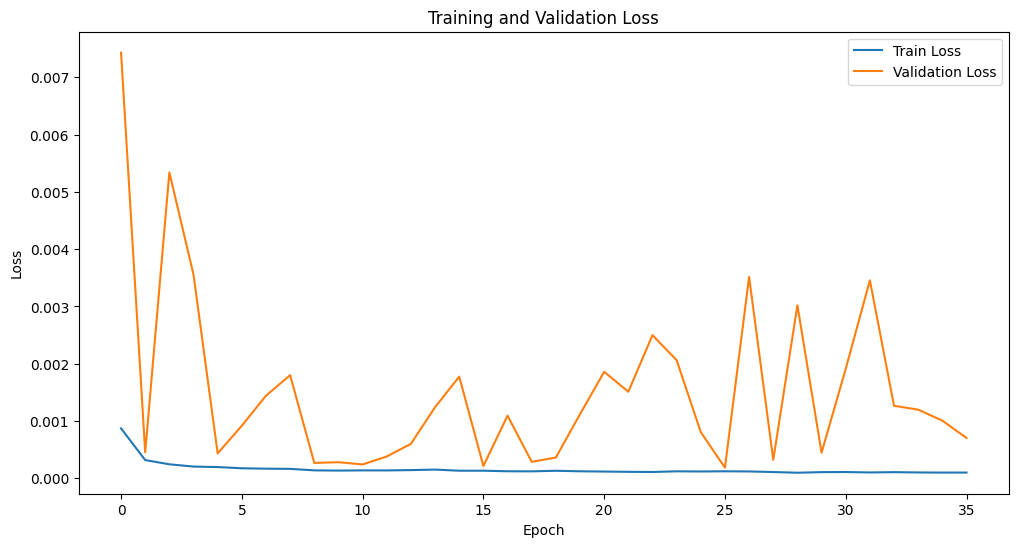

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# predictions
y_pred = model.predict(X_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
y_pred

array([[ 7734.4316],
       [ 7759.8784],
       [ 7747.505 ],
       ...,
       [17238.7   ],
       [17278.615 ],
       [17549.598 ]], dtype=float32)

In [ ]:
# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
y_pred

array([[35559700.],
       [35676692.],
       [35619804.],
       ...,
       [79256232.],
       [79439752.],
       [80685608.]], dtype=float32)

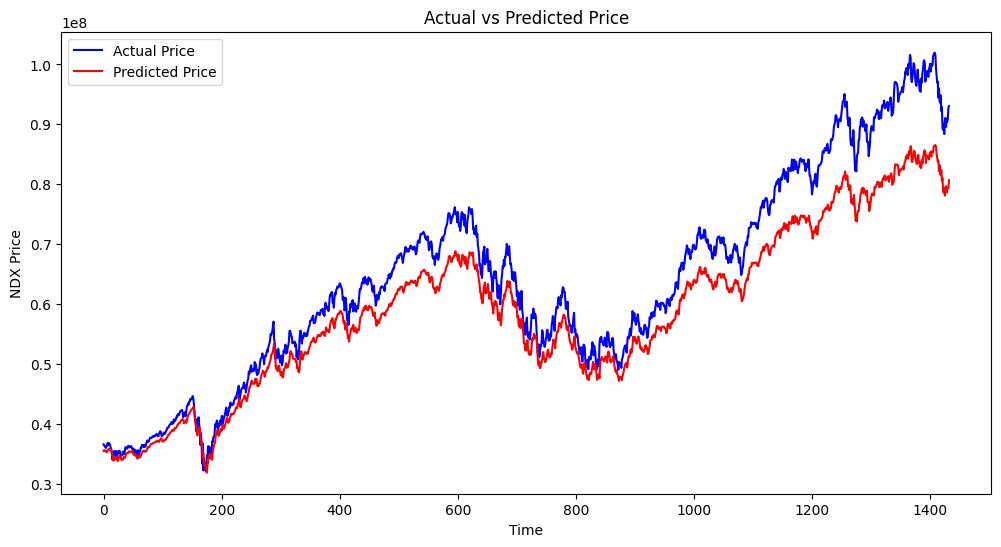

In [ ]:
# Actual vs Predicted Price
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red')
plt.xlabel('Time')
plt.ylabel('NDX Price')
plt.legend()
plt.title('Actual vs Predicted Price')
plt.show()

In [ ]:
print("Sample predicted values:", y_pred[:10].flatten())
print("Sample actual values:", y_test[:10].flatten())


Sample predicted values: [35559700. 35676692. 35619804. 35492076. 35480980. 35312832. 35417516.
 35600816. 35815984. 35691540.]
Sample actual values: [36628626.14349039 36445412.5309332  36269232.21268135 36339897.4020026
 36021607.72230457 36344450.0738351  36571753.66409956 36829446.56333669
 36458239.93076107 36858596.68352655]


In [ ]:
print("Scaler Min Value:", scaler.data_min_)
print("Scaler Max Value:", scaler.data_max_)
print("First 10 Predicted Values (Inverse Transformed):", y_pred[:10])
print("First 10 Actual Values (Inverse Transformed):", y_test[:10])


Scaler Min Value: [107.16000366]
Scaler Max Value: [4704.72998047]
First 10 Predicted Values (Inverse Transformed): [[35559700.]
 [35676692.]
 [35619804.]
 [35492076.]
 [35480980.]
 [35312832.]
 [35417516.]
 [35600816.]
 [35815984.]
 [35691540.]]
First 10 Actual Values (Inverse Transformed): [[36628626.14349039]
 [36445412.5309332 ]
 [36269232.21268135]
 [36339897.4020026 ]
 [36021607.72230457]
 [36344450.0738351 ]
 [36571753.66409956]
 [36829446.56333669]
 [36458239.93076107]
 [36858596.68352655]]


In [ ]:
# Performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
directional_accuracy = np.mean((np.sign(np.diff(y_test.flatten())) == np.sign(np.diff(y_pred.flatten())))) * 100
mape_percentage = 100 - mape
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print(f"Mape Percentage: {mape_percentage:.2f}%")



Mean Squared Error: 41174035201002.8438
Root Mean Squared Error: 6416699.7125
Mean Absolute Error: 5285087.2025
R-squared Score: 0.8601
Explained Variance Score: 0.9543
Mean Absolute Percentage Error: 7.4131
Directional Accuracy: 49.65%
Mape Percentage: 92.59%
